## 1 Introduction

This tutorial introduces the basic features for simulating titratable systems via the constant pH method.
The constant pH method is one of the methods implemented for simulating systems with chemical reactions within the Reaction Ensemble module. It is a Monte-Carlo method designed to model an acid-base ionization reaction at a given (fixed) value of solution pH.

We will consider a homogeneous aqueous solution of a titratable acidic species $\mathrm{HA}$ that can dissociate in a reaction, that is characterized by the equilibrium constant $\mathrm{p}K_A=-\log_{10} K_A$
$$\mathrm{HA} \Leftrightarrow \mathrm{A}^- + \mathrm{H}^+$$


If $N_0 = N_{\mathrm{HA}} + N_{\mathrm{A}^-}$ is the number of titratable groups in solution, then we define the degree of dissociation $\alpha$ as:

$$\alpha = \dfrac{N_{\mathrm{A}^-}}{N_0}.$$

This is one of the key quantities that can be used to describe the acid-base equilibrium. Usually, the goal of the simulation is to predict the value of $\alpha$ under given conditions in a complex system with interactions. In this tutorial, we will simulate only ideal systems (without intermolecular interactions) to show that in such case our simulations reproduce the well-known analytical solutions.

### 1.1 The Chemical Equilibrium and Reaction Constant

The equilibrium reaction constant describes the chemical equilibrium of a given reaction. The values of equilibrium constants for various reactions can be found in tables. For the acid-base ionization reaction, the equilibrium constant is conventionally called the acidity constant, and it is defined as
\begin{equation}
K_A = \frac{a_{\mathrm{H}^+} a_{\mathrm{A}^-} } {a_{\mathrm{HA}}}
\end{equation}
where $a_i$ is the activity of species $i$. It is related to the chemical potential and to the concentration
The degree of dissociation can also be expressed via a ratio of concentrations:

\begin{equation}
\mu_i = \mu_i^\mathrm{ref} + k_{\mathrm{B}}T \ln a_i
\,,\qquad
a_i = \frac{c_i \gamma_i}{c^{\ominus}}
\end{equation}
where $\gamma_i$ is the activity coefficient, and $c^{0}$ is the (arbitrary) reference concentration, often chosen to be the standard concentration, $c^0 = 1\,\mathrm{mol\,dm^{-3}}$ and $\mu_i^\mathrm{ref}$ is the reference chemical potential.
Note that $K$ is a dimensionless quantity but its numerical value depends on the choice of $c^0$.
For an ideal system, $\gamma_i=1$ by definition, whereas for an interacting system $\gamma_i$ is a non-trivial function of the interactions. For an ideal system we can rewrite $K$ in terms of equilibrium concentrations
\begin{equation}
K_A \overset{\mathrm{ideal}}{=} \frac{c_{\mathrm{H}^+} c_{\mathrm{A}^-} } {c_{\mathrm{HA}} c^{\ominus}}
\end{equation}

The ionization degree can also be expressed via the ratio of concentrations:
\begin{equation}
\alpha 
= \frac{N_{\mathrm{A}^-}}{N_0} 
= \frac{N_{\mathrm{A}^-}}{N_{\mathrm{HA}} + N_{\mathrm{A}^-}}
= \frac{c_{\mathrm{A}^-}}{c_{\mathrm{HA}}+c_{\mathrm{A}^-}}
= \frac{c_{\mathrm{A}^-}}{c_{0}}.
\end{equation}
where $c_0=c_{\mathrm{HA}}+c_{\mathrm{A}^-}$ is the total concentration of titratable groups irrespective of their ionization state.
Then, we can characterize the acid-base ionization equilibrium using the ionization degree and pH, defined as
\begin{equation}
\mathrm{pH} = -\log_{10} a_{\mathrm{H^{+}}} \overset{\mathrm{ideal}}{=} -\log_{10} (c_{\mathrm{H^{+}}} / c^{\ominus})
\end{equation}
Substituting for the ionization degree and pH into the expression for $K_A$ we obtain the Henderson-Hasselbalch equation
\begin{equation}
\mathrm{pH}-\mathrm{p}K_A = \log_{10} \frac{\alpha}{1-\alpha}
\end{equation}
One important implication of the Henderson-Hasselbalch equation is that at a fixed pH value the ionization degree of an ideal acid is independent of concentration. Another important implication is that it does not depend on the absolute values of $\mathrm{p}K_A$ or $\mathrm{pH}$, but only on the difference, $\mathrm{pH}-\mathrm{p}K_A$.

### 1.2 Constant pH Method

The constant pH method [Reed1992] is designed to simulate an acid-base ionization reaction at a given pH. It assumes that the simulated system is coupled to an implicit reservoir of $\mathrm{H^+}$ ions but exchange of ions with this reservoir is not explicitly simulated. Therefore, the number of $\mathrm{H}^+$ ions in the simulation box does not correspond to the chosen pH. This may lead to artifacts when simulating interacting systems, especially at high of low pH values. Discussion of these artifacts is beyond the scope of this tutorial (see e.g. [Landsgesell2019] for further details).

In Espresso, the forward step of the ionization reaction (from left to right) is implemented by 
changing the chemical identity (particle type) of a randomly selected $\mathrm{HA}$ particle to $\mathrm{A}^-$, and inserting another particle that represents $\mathrm{H}^+$. In the reverse direction (from right to left), the chemical identity (particle type) of a randomly selected $\mathrm{A}^{-}$ is changed to $\mathrm{HA}$, and a randomly selected $\mathrm{H}^+$ is deleted from the simulation box. The probability of proposing the  forward reaction step is $P_\text{prop}=N_\mathrm{HA}/N_0$, and probability of proposing the reverse step is $P_\text{prop}=N_\mathrm{A}/N_0$. The trial move is accepted with the acceptance probability

$$ P_{\mathrm{acc}} = \operatorname{min}\left(1, \exp(-\beta \Delta E_\mathrm{pot} \pm \ln_{10} (\mathrm{pH - p}K_A) ) \right)$$

Here $\Delta E_\text{pot}$ is the potential energy change due to the reaction, while $\text{pH - p}K$ is an input parameter. 
The signs $\pm 1$ correspond to the forward and reverse direction of the ionization reaction, respectively. 



## 2 Setup
We start by creating a system instance with an arbitrary box length of 35 $\sigma$ and creating `N0` titratable units (in the associated state). We set the dissociation constant of the acid to $\mathrm{p}K_A=4.88$, that is the acidity constant of propionic acid. We choose propionic acid as it resembles the repeating unit of polyacrylic acid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import espressomd
from espressomd import reaction_ensemble
import itertools

# System parameters
#############################################################
BOX_L= 35 # box size is arbitrary (see Henderson-Hasselbalch equation)

# particle types of different species
TYPE_HA = 0
TYPE_A = 1
TYPE_H = 2

# acidity constant
pK = 4.88
K = 10**(-pK)

# range of pH values to be used in calculations
num_pHs=15 # number of pH values

n_blocks=16  # number of block to be used in data analysis
block_len = 10  # number of samples per block
num_samples = n_blocks * block_len; # number of reaction samples per each pH value
offset=2.0; # range of pH values to be used
pHmin=pK-offset # lowest pH value to be used
pHmax=pK+offset # highest pH value to be used
pHs = np.linspace(pHmin, pHmax, num_pHs); # list of pH values

N0 = 10  # number of titratable units in the box

# Integration parameters
#############################################################
system = espressomd.System(box_l=[BOX_L] * 3)
system.set_random_state_PRNG()
np.random.seed(seed=10)

for i in range(N0):
    system.part.add(pos=np.random.random(3) * system.box_l, type=TYPE_HA)

In the first step, we initialize the reaction ensemble, by setting the temperature, exclusion radius and seed of the random number generator. Because we are simulating an ideal system, 
we set the temperature to an arbitrary value. In an interacting system the exclusion radius ensures that particle insertions too close to other particles are not attempted. Such insertions would make the subsequent Langevin dynamics integration unstable. Because the particles are not interacting, we set the exclusion radius to $0.0$. We set the seed to a constant value to ensure reproducible results.

In [2]:
RE = reaction_ensemble.ConstantpHEnsemble(
        temperature=1, exclusion_radius=0.0, seed=77)

The next step is to define the reaction system and the seed of the pseudo-random number generator which is used for the Monte-Carlo steps.
The order in which species are written in the lists of reactants and products is very important. When a reaction move is performed, identity of the first species in the list of reactants is changed to the first species in the list of products, the second reactant species is changed to the second product species, and so on. If the reactant list has more species than the product list, then excess reactant species are deleted from the system. If the product list has more species than the reactant list, then product the excess product species are created and randomly placed inside the simulation box. This is especially relevant if some of the species belong to a chain-like molecule.

In the example below, the order of reactants and produces ensures that identity of $\mathrm{HA}$ is changed to $\mathrm{A^{-}}$ and vice versa, while $\mathrm{H^{+}}$ is inserted/deleted in the reaction move. Reversing the order of products in our reaction (i.e. from  `product_types=[TYPE_H, TYPE_A]` to `product_types=[TYPE_A, TYPE_H]`), would result in a reaction move, where the identity HA would be changed to $\mathrm{H^{+}}$, while $\mathrm{A^{-}}$ would be inserted/deleted at a random position in the box.
We also assign charges to each type because in general the charge will play a role in simulations with electrostatic interactions. As an easy task for the interested reader we propose to adapt the tutorial to account for electrostatic interactions. Therefore we keep these values for the needed charge assignments in place, although they are not needed for an ideal system.

In [3]:
RE.add_reaction(gamma=K, reactant_types=[TYPE_HA], reactant_coefficients=[1],
                product_types=[TYPE_A, TYPE_H], product_coefficients=[1, 1],
                default_charges={TYPE_HA: 0, TYPE_A: -1, TYPE_H: +1})
print(RE.get_status())

{'reactions': [{'reactant_coefficients': [1], 'reactant_types': [0], 'product_types': [1, 2], 'product_coefficients': [1, 1], 'gamma': 1.3182567385564074e-05}, {'reactant_coefficients': [1, 1], 'reactant_types': [1, 2], 'product_types': [0], 'product_coefficients': [1], 'gamma': 75857.75750291836}], 'temperature': 1.0, 'exclusion_radius': 0.0}


Next we perform simulations at different pH values. The system must be equilibrated at each pH before taking samples.
Calling `RE.reaction(X)` attempts in total `X` reactions (in back and forward directions).
We also plot the acceptance rate for the dissociation reaction and the association reaction for the first pH value which we set.

In [4]:
# empty lists as placeholders for collecting data
numAs = []; # number of A- species observed at each sample

# collect the data
for pH in pHs:
    print("pH is {:.2f}".format(pH))
    RE.constant_pH = pH
    RE.reaction(100 * N0) # pre-equilibration to the new pH
    numAs_current = []; # temporary data storage for a given pH
    for i in range(num_samples):
        RE.reaction(N0 + 1) # should be at least one reaction attempt per particle
        numAs_current.append(system.number_of_particles(type=TYPE_A))
    numAs.append(numAs_current) #
    print("average number of A-: {}".format(np.mean(numAs_current)))

pH is 2.88
average number of A-: 0.11875
pH is 3.17
average number of A-: 0.225
pH is 3.45
average number of A-: 0.35625
pH is 3.74
average number of A-: 0.69375
pH is 4.02
average number of A-: 1.3
pH is 4.31
average number of A-: 2.39375
pH is 4.59
average number of A-: 3.5875
pH is 4.88
average number of A-: 5.025
pH is 5.17
average number of A-: 6.8625
pH is 5.45
average number of A-: 8.05
pH is 5.74
average number of A-: 8.8125
pH is 6.02
average number of A-: 9.26875
pH is 6.31
average number of A-: 9.64375
pH is 6.59
average number of A-: 9.84375
pH is 6.88
average number of A-: 9.90625


## 3 Results

Finally we plot our results and compare them to the analytical results obtained from the Henderson-Hasselbalch equation.

### 3.1 Statistical Uncertainty

The molecular simulation produces a sequence of snapshots of the system, that 
constitute a Markov chain. It is a sequence of realizations of a random process, where
the next value in the sequence depends on the preceding one. Therefore,
the subsequent values are correlated. To estimate statistical error of the averages
determined in the simulation, one needs to correct for the correlations.

Here, we will use a rudimentary way of correcting for correlations, termed the binning method.
We refer the reader to specialized literature for a more sophisticated discussion [Janke2002]. The general idea is to group a long sequence of correlated values into a rather small number of blocks, and compute an average per each block. If the blocks are big enough, they
can be considered uncorrelated, and one can apply the formula for standard error of the mean of uncorrelated values. If the number of blocks is small, then they are uncorrelated but the obtained error estimates has a high uncertainty. If the number of blocks is high, then they are too short to be uncorrelated, and the obtained error estimates are systematically lower than the correct value. Therefore, the method works well only if the sample size is much greater than the autocorrelation time.

In the example below, we use a fixed number of 8 blocks to obtain the error estimates. To check for consistency, we estimate the autocorrelation time, and print a warning message if some blocks contain less than 100 uncorrelated values. Intentionally, we make our simulation slightly too short, so that it does not produce enough uncorrelated samples. We encourage the reader to vary the number of blocks or the number of samples to see how the estimated error changes with these parameters.

block_size: 10


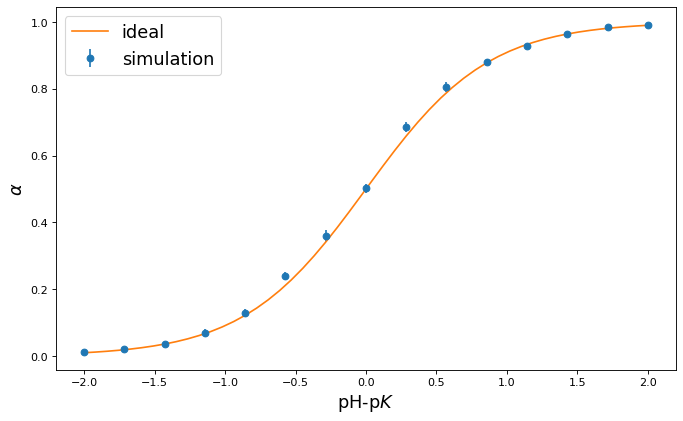

In [5]:
# statistical analysis of the results
numAs=np.array(numAs)
block=0;
# this number of blocks is recommended by Janke as a reasonable compromise
# between the conflicing requirements on block size and number of blocks
block_size=int(numAs.shape[1]/n_blocks);
print("block_size:", block_size);
block_average=np.zeros((n_blocks,numAs.shape[0])); # initialize the array of per-block averages
# calculate averages per each block
for block in range(0,n_blocks):
    block_average[block]=np.average(numAs[:,block*block_size:(block+1)*block_size],axis=1)

# calculate the average and average of the square
av_numAs=np.average(numAs,axis=1)
av2_numAs=np.average(numAs*numAs,axis=1);
# calculate the variance of the block averages
block_var=np.var(block_average,axis=0);
# calculate standard error of the mean
err_numAs=np.sqrt(block_var/(n_blocks-1));

# calculate the ionization degree
av_alpha=av_numAs/N0;
err_alpha=err_numAs/N0;
# the reference data from Henderson-Hasselbalch equation
def ideal_alpha(pH, pK):
    return 1. / (1 + 10**(pK - pH))


# plot the simulation results compared with the ideal titration curve
plt.figure(figsize=(10, 6), dpi=80)
plt.errorbar(pHs - pK, av_alpha, err_alpha, marker='o', linestyle='none',\
             label=r"simulation")
pHs2 = np.linspace(pHmin, pHmax, num=50)
plt.plot(pHs2 - pK, ideal_alpha(pHs2, pK), label=r"ideal")
plt.xlabel('pH-p$K$', fontsize=16)
plt.ylabel(r'$\alpha$', fontsize=16)
plt.legend(fontsize=16)
plt.show()

The simulation results very well compare with the analytical solution of Henderson-Hasselbalch equation. There are only minor deviations, and the estimated errors are small too.

It is useful to check whether the estimated errors are consistent with the assumptions that were used to obtain them. To do this, we follow [Janke2000] to estimate the number of uncorrelated samples per block, and check whether each block contains a sufficient number of uncorrelated samples (we choose 10 uncorrelated samples per block as the threshold value).

In [6]:
# estimate autocorrelation time using the formula given by Janke
# this assumes that the errors have been correctly estimated
tau=np.zeros(av_numAs.shape);
for val in range(0,av_numAs.shape[0]):
    if (av_numAs[val] == 0): 
        tau[val]=-1.0;
    else:
        tau[val]=0.5*block_size*n_blocks/(n_blocks-1)*block_var[val]/(av2_numAs[val]-av_numAs[val]*av_numAs[val]);
print("av = ", av_numAs);
print("err = ", err_numAs);
print("tau = ", tau);

# check if the blocks contain enough data for reliable error estimates
print("uncorrelated samples per block:\nblock_size/tau = ",\
      block_size/tau);
threshold=10.; # block size should be much greater than the correlation time
if(np.any(block_size/tau<threshold)):
    print("\nWarning: some blocks may contain less than ", threshold, "uncorrelated samples."\
          "\nYour error estimated may be unreliable."\
          "\nPlease, check them using a more sophisticated method or run a longer simulation.")
    print("? block_size/tau > threshold ? :", block_size/tau>threshold);
else:
    print("\nAll blocks seem to contain more than ", threshold, "uncorrelated samples.\
    Error estimates should be OK.");


av =  [0.11875 0.225   0.35625 0.69375 1.3     2.39375 3.5875  5.025   6.8625
 8.05    8.8125  9.26875 9.64375 9.84375 9.90625]
err =  [0.0367636  0.05123475 0.06580828 0.11671502 0.11761519 0.11234944
 0.17196778 0.13768926 0.15380588 0.14691267 0.0773924  0.07676737
 0.05474848 0.03531849 0.03815402]
tau =  [1.03322135 0.93593315 1.09349443 1.50324191 0.87830688 0.61154613
 1.09158196 0.56185845 0.88286318 1.04016064 0.49662618 0.63153856
 0.75683229 0.5893118  1.19492318]
uncorrelated samples per block:
block_size/tau =  [ 9.67846821 10.68452381  9.14499399  6.65228924 11.38554217 16.35199608
  9.1610162  17.79807692 11.32678336  9.61389961 20.13586957 15.834346
 13.21296699 16.96894572  8.36873882]

Your error estimated may be unreliable.
Please, check them using a more sophisticated method or run a longer simulation.
? block_size/tau > threshold ? : [False  True False False  True  True False  True  True False  True  True
  True  True False]


To look in more details at the statistical accuracy, it is useful to plot the deviations from the analytical result. This provides another way to check the consistency of error estimates.  For 68% of the results, the deviation from the analytical result should be within the error bar, whereas 95% of the results should be within two times the error bar. Indeed, if you plot the deviations by running the script below, you should observe that most of the results are within one error bar from the analytical solution, a smaller fraction  of the results is slightly further than one error bar, and one or two might be about two error bars apart.

Try increasing the number of samples of in the simulation to see how the estimated error changes, and whether the consistency is still satisfied.

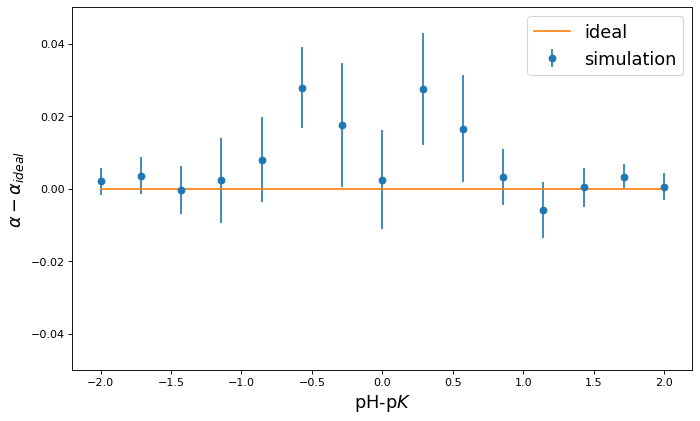

In [9]:
# plot the deviations from the ideal result
plt.figure(figsize=(10, 6), dpi=80)
plt.ylim((-0.05,0.05))
plt.errorbar(pHs - pK, av_alpha-ideal_alpha(pHs, pK),\
             err_alpha, marker='o', linestyle='none', label=r"simulation")
plt.plot(pHs - pK, 0.0*ideal_alpha(pHs, pK), label=r"ideal")
plt.xlabel('pH-p$K$', fontsize=16)
plt.ylabel(r'$\alpha - \alpha_{ideal}$', fontsize=16)
plt.legend(fontsize=16)
plt.show()

## References

[Janke2002] Janke W. Statistical Analysis of Simulations: Data Correlations and Error Estimation,
In Quantum Simulations of Complex Many-Body Systems: From Theory to Algorithms, Lecture Notes,
J. Grotendorst, D. Marx, A. Muramatsu (Eds.), John von Neumann Institute for Computing, Jülich,
NIC Series, Vol. 10, ISBN 3-00-009057-6, pp. 423-445, 2002.

[Landsgesell2019] Landsgesell, J.; Nová, L.; Rud, O.; Uhlík, F.; Sean, D.; Hebbeker, P.; Holm, C.; Košovan, P. Simulations of Ionization Equilibria in Weak Polyelectrolyte Solutions and Gels. Soft Matter 2019, 15 (6), 1155–1185. https://doi.org/10.1039/C8SM02085J.,
    
[Reed1992] Reed, C. E.; Reed, W. F. Monte Carlo Study of Titration of Linear Polyelectrolytes. The Journal of Chemical Physics 1992, 96 (2), 1609–1620. https://doi.org/10.1063/1.462145.

[Smith1994] Smith, W. R.; Triska, B. The Reaction Ensemble Method for the Computer Simulation of Chemical and Phase Equilibria. I. Theory and Basic Examples. The Journal of Chemical Physics 1994, 100 (4), 3019–3027. https://doi.org/10.1063/1.466443.